# Logistic Regression on SMOTE data

In [1]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import dash
import plotly.express as px
import tensorflow as tf
import sys  
sys.path.insert(0, '../')
import common_functions
import common_plotting_functions

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, ClassifierMixin

In [2]:
# Fix random seed for reproductibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

## Data

In [3]:
# Read data using pandas
X_train = pd.read_csv('../Datasets/bin_classif_smote_baseline_x_train.csv')
df_y_train = pd.read_csv('../Datasets/bin_classif_smote_baseline_y_train.csv')
X_dev = pd.read_csv('../Datasets/X_dev.csv')
df_y_dev = pd.read_csv('../Datasets/y_dev.csv')
X_test = pd.read_csv('../Datasets/X_test.csv')
df_y_test = pd.read_csv('../Datasets/y_test.csv')

In [4]:
# Transform target df into ndarray
y_train= df_y_train.values.ravel()
y_dev = df_y_dev.values.ravel()
y_test = df_y_test.values.ravel()

In [5]:
# Manually select desired features
columns_to_drop = ['sosfhi', 'sosfhf', 'sos20rs', 'mpa']
X_dev = X_dev.drop(columns=columns_to_drop)
X_test = X_test.drop(columns=columns_to_drop)

In [6]:
# Compute X_traindev and y_traindev
X_traindev = pd.concat([X_train, X_dev])
X_traindev.reset_index(inplace=True, drop=True)
y_traindev = np.concatenate((y_train, y_dev), axis=0)

## Utils

In [7]:
# Function to create a model with a cutoff point and a preprocessor
def create_model(cutoff, preprocessor):
    # Create the classifier
    lr = LRWithCustomThreshold(cutoff=cutoff)
    # Create the normalization pipeline
    pipeline = Pipeline([("preprocess", preprocessor), ("lr", lr)])
    return pipeline

In [8]:
# Function for stratified 5-fold cv with different cut-off points and preprocesor 
def cross_validate_for_thresholds_with_preprocessor(thresholds, preprocessor, X, y):
    for threshold in thresholds:
        model = create_model(threshold, preprocessor)
        # Perform the cross validation
        # Use Stratified KFold for cross_validation splitting
        results = common_functions.perform_cross_validation(model, X, y)
        # Print mean results
        print('---------------------------------', threshold)
        common_functions.print_cv_metrics(results)

In [9]:
# Custom cross validation
def custom_cross_validate(X_full, y_full):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    for train, test in skf.split(X_full, y_full): 
        model = create_model(cutoff, preprocessor_standard_scaling)
        model.fit(X_full.iloc[train], y_full[train])

        # Predict on the validation split
        predictions = model.predict(X_full.iloc[test])
        predictions = predictions.reshape(predictions.shape[0])
        common_functions.evaluate_performance(y_full[test] == 1, predictions == 1)  

### Default model

In [10]:
# Custom model based on logistic regression with a specified cut-off point
class LRWithCustomThreshold(BaseEstimator, ClassifierMixin):
    def __init__(self, cutoff):
        self.cutoff=cutoff
        self.lr = LogisticRegression(class_weight='balanced')
    
    def fit(self, X, y=None):
        self.lr.fit(X, y)
    
    def predict(self, X, y=None):
        predictions_as_probabilities = self.lr.predict_proba(X)
        return np.where(predictions_as_probabilities[:,1] > self.cutoff, 1, 0)
    
    def predict_proba(self, X, y=None, with_tree=False):
        return self.lr.predict_proba(X)

In [11]:
# Create the preprocessors
selected_features = X_traindev.columns
preprocessor_normalization = ColumnTransformer([
        ("normalize", Normalizer(), selected_features)],
        remainder="drop")

preprocessor_standard_scaling = ColumnTransformer([
        ("scale", StandardScaler(), selected_features)],
        remainder="drop")

In [12]:
# Define a set of thresholds (to be used as cut-off points) to experiment with
thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]

#### After normalization

In [13]:
# Cross validation for pipeline with normalization for different thresholds
cross_validate_for_thresholds_with_preprocessor(thresholds, preprocessor_normalization, X_traindev, y_traindev)

--------------------------------- 0.5
---TRAIN---
Mean recall:  0.90632088890393
Mean precision:  0.44705459542466813
Mean accuracy:  0.85019833742122
Mean F1:  0.5987567041294133
---TEST---
Mean recall:  0.90575793745524
Mean precision:  0.44676575376428407
Mean accuracy:  0.8499547656643415
Mean F1:  0.5982848012310326
--------------------------------- 0.6
---TRAIN---
Mean recall:  0.8247740264549055
Mean precision:  0.4793907377159671
Mean accuracy:  0.8679274717185136
Mean F1:  0.6063425060915846
---TEST---
Mean recall:  0.8250497334288216
Mean precision:  0.48127031676880777
Mean accuracy:  0.8686060388504206
Mean F1:  0.6077781540319036
--------------------------------- 0.7
---TRAIN---
Mean recall:  0.7248871003222008
Mean precision:  0.5081308727186675
Mean accuracy:  0.8795323478817301
Mean F1:  0.597453070118395
---TEST---
Mean recall:  0.7240455160340573
Mean precision:  0.5082769741239564
Mean accuracy:  0.8793237787758802
Mean F1:  0.597053419122749
------------------------

#### After standard scaling

In [14]:
# Cross validation for pipeline with standard scaling
cross_validate_for_thresholds_with_preprocessor(thresholds, preprocessor_standard_scaling, X_traindev, y_traindev)

--------------------------------- 0.5
---TRAIN---
Mean recall:  0.9030749920619359
Mean precision:  0.6726049813741819
Mean accuracy:  0.9338332783943157
Mean F1:  0.770978380877461
---TEST---
Mean recall:  0.9034980504495902
Mean precision:  0.6704197672476818
Mean accuracy:  0.9331899883274826
Mean F1:  0.7695074764971379
--------------------------------- 0.6
---TRAIN---
Mean recall:  0.868651365197735
Mean precision:  0.7040756476417747
Mean accuracy:  0.938774472456785
Mean F1:  0.7777488957739046
---TEST---
Mean recall:  0.8679525742022758
Mean precision:  0.7046818561069392
Mean accuracy:  0.9387574085606374
Mean F1:  0.7776711040320494
--------------------------------- 0.7
---TRAIN---
Mean recall:  0.824633380878771
Mean precision:  0.7333780480255758
Mean accuracy:  0.941401636607608
Mean F1:  0.7763327083385078
---TEST---
Mean recall:  0.8250672395957668
Mean precision:  0.7351254283516131
Mean accuracy:  0.9416801400798981
Mean F1:  0.7772911170963475
------------------------

### Train and test

In [15]:
# Select the cutoff point
cutoff = 0.6

In [16]:
# Initialize model
model = create_model(cutoff, preprocessor_standard_scaling)
# Fit the best performing pipeline, as it has not been fit yet (only cross-validated)
model.fit(X_traindev, y_traindev)
# Use the model to predict probabilities (i.e. the actual value) instead of the label
y_predicted = model.predict(X_test)

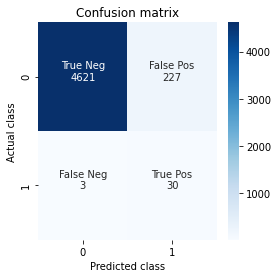

Accuracy:  0.9528785085023561
Recall:  0.9090909090909091
Precision:  0.11673151750972763
F1 score:  0.20689655172413796
Specificity:  0.9531765676567657


(0.9528785085023561, 0.9090909090909091, 0.11673151750972763)

In [17]:
# Display confusion matrix and evaluation metrices
common_functions.evaluate_performance(y_test, y_predicted)

#### Cross validation on the entire dataset available

In [18]:
# Create the full dataset by adding all the samples together
X_full = pd.concat([X_traindev, X_test])
y_full = np.concatenate((y_traindev, y_test), axis=0)

In [19]:
# Cross validation the best model so far using the entire dataset
cross_validate_for_thresholds_with_preprocessor([cutoff], preprocessor_standard_scaling, X_full, y_full)

--------------------------------- 0.6
---TRAIN---
Mean recall:  0.8713296398891966
Mean precision:  0.6416936777589985
Mean accuracy:  0.9423116883116883
Mean F1:  0.7390815413004957
---TEST---
Mean recall:  0.8692520775623269
Mean precision:  0.6423440956825077
Mean accuracy:  0.9421818181818182
Mean F1:  0.738477263355075


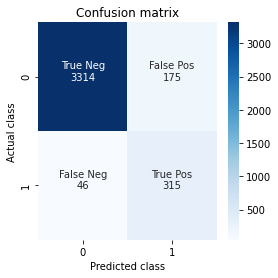

Accuracy:  0.9425974025974025
Recall:  0.8725761772853186
Precision:  0.6428571428571429
F1 score:  0.7403055229142187
Specificity:  0.9498423617082259


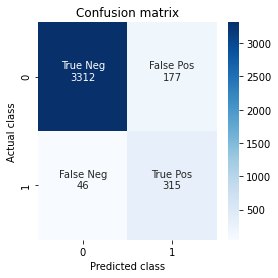

Accuracy:  0.9420779220779221
Recall:  0.8725761772853186
Precision:  0.6402439024390244
F1 score:  0.738569753810082
Specificity:  0.9492691315563199


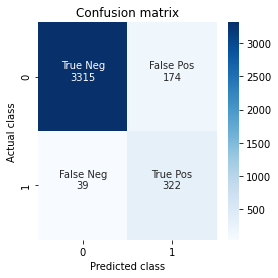

Accuracy:  0.9446753246753247
Recall:  0.8919667590027701
Precision:  0.6491935483870968
F1 score:  0.7514585764294048
Specificity:  0.9501289767841788


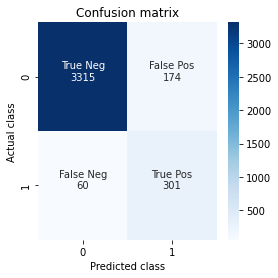

Accuracy:  0.9392207792207792
Recall:  0.8337950138504155
Precision:  0.6336842105263157
F1 score:  0.7200956937799041
Specificity:  0.9501289767841788


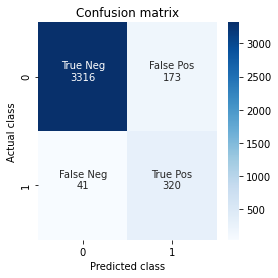

Accuracy:  0.9444155844155844
Recall:  0.8864265927977839
Precision:  0.6490872210953347
F1 score:  0.7494145199063231
Specificity:  0.9504155918601318


In [20]:
# Look at the confusion matrices per folds
custom_cross_validate(X_full, y_full)